Projeto de Transfer Learning em Python
O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.  

In [93]:
import os
import zipfile
from PIL import Image
from os import listdir
from os.path import isdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from shutil import copyfile

Os aquivos com as imagens foram baixadas em arquivos zip e com a biblioteca zipfile foram desconpactadas para o diretório home.

In [94]:
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/home/cats-and-dogs.zip"

local_zip = '/home/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/home')
zip_ref.close()

--2025-02-10 20:52:32--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.39.190.10, 2600:1406:bc00:1387::317f, 2600:1406:bc00:1388::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.39.190.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/home/cats-and-dogs.zip’

/home/cats-and-dogs 100%[===================>] 786.67M  84.1MB/s    in 12s     

2025-02-10 20:52:44 (64.1 MB/s) - ‘/home/cats-and-dogs.zip’ saved [824887076/824887076]



Para verificar se as imagens foram baixadas nas respectivas páginas vamos usar o print e len para verificar quandas imagens existem na pasta /home/PetImages/Cat e /home/PetImages/Cat

In [49]:
print(len(os.listdir('/home/PetImages/Cat/')))
print(len(os.listdir('/home/PetImages/Dog/')))

12501
12501


## Tamanho da imagens e épocas de treinamento

Será usado o tamanho da image de 150x150 pixels e 100 épocas de treinamentos para duas classes, que são cães e gatos.

In [95]:
IMAGE_SIZE = [150,150]
EPOCHS = 225
CLASSES = 2

## Verificação das imagens

Depois de verificar 12501 imagens de gatos e cachorros foram baixadas nons diretórios corretamente vamos usar os.mkdir para o diretório de gatos e cachorros e criar os subdiretórios dos trainamentos e validações.

In [ ]:
try:
  os.mkdir('/home/cats-v-dogs')
  os.mkdir('/home/cats-v-dogs/training')
  os.mkdir('/home/cats-v-dogs/testing')
  os.mkdir('/home/cats-v-dogs/training/cats')
  os.mkdir('/home/cats-v-dogs/training/dogs')
  os.mkdir('/home/cats-v-dogs/testing/cats')
  os.mkdir('/home/cats-v-dogs/testing/dogs')
except OSError as e:
  print("Error creating director: {e}")
  pass

In [18]:
cat_fnames = os.listdir('/home/PetImages/Cat')
print("Cats: ", cat_fnames[:10])
dog_fnames = os.listdir('/home/PetImages/Dog')
dog_fnames.sort()
print("Dogs: ", dog_fnames[:10])

Cats:  ['11300.jpg', '8275.jpg', '9973.jpg', '5381.jpg', '9779.jpg', '4471.jpg', '8566.jpg', '465.jpg', '4315.jpg', '8936.jpg']
Dogs:  ['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg']


## Definição das imagens para os diretórios e subdiretórios

A função definida vai dividir entre o que está no diretório original SOURCE, as imagens para serão copiadas para o diretório de treino TRAINING, o diretório de test TESTING e a proporção usada para treino SPLIT_SIZE em 0.9 ou 90%.

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
        files.append(filename)
    else:
        print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

CAT_SOURCE_DIR = "/home/PetImages/Cat/"
TRAINING_CATS_DIR = "/home/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/home/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/home/PetImages/Dog/"
TRAINING_DOGS_DIR = "/home/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/home/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

## Verificação dos subdiretórios

Os subdiretórios que receberam a imagens de treino e teste foram impressos para verificar se estão com s imagens separadas.

In [25]:
print("Total training cats images: ", len(os.listdir('/home/cats-v-dogs/training/cats/')))
print("Total training dogs images: ",len(os.listdir('/home/cats-v-dogs/training/dogs/')))
print("Total testing cats images: ",len(os.listdir('/home/cats-v-dogs/testing/cats/')))
print("Total testing dogs images: ",len(os.listdir('/home/cats-v-dogs/testing/dogs/')))

Total training cats images:  11250
Total training dogs images:  11250
Total testing cats images:  1250
Total testing dogs images:  1250


## Verificação das imagens

Vamos verificar as imagens para ter uma ideia melhor de como são os conjuntos de dados de cães e gatos

In [27]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

pic_index = 0

## Exibição de lotes de fotos

Será exibido um lote de 5 fotos de gatos e 5 de cães.

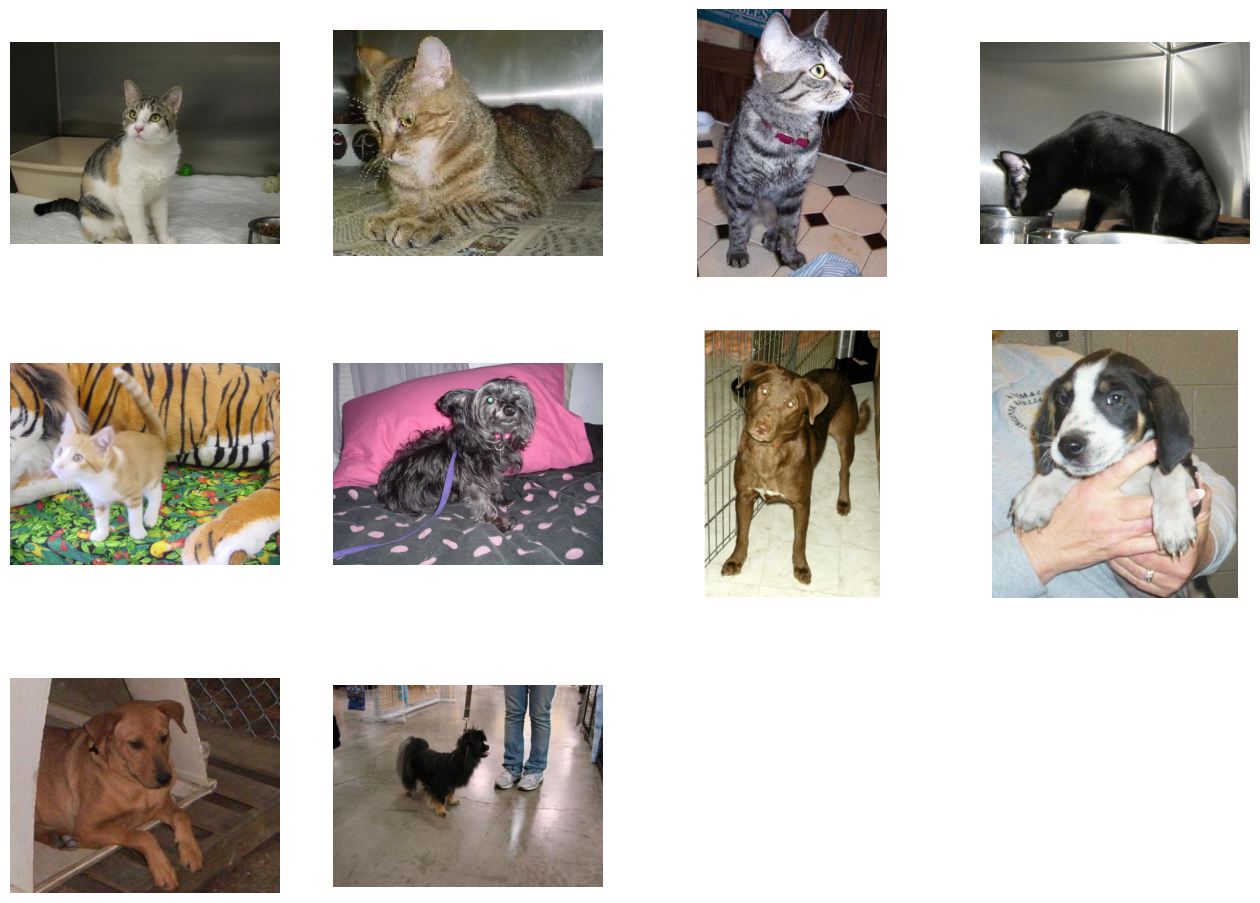

In [28]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 5
next_cat_pix = [os.path.join(TRAINING_CATS_DIR, fname)
                for fname in cat_fnames[pic_index-5:pic_index]]
next_dog_pix = [os.path.join(TRAINING_DOGS_DIR, fname)
                for fname in dog_fnames[pic_index-5:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):

  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Definições das Redes Neurais Convolucionais - RNC

Com o uso da API do Keras tensorflow.

**model = tf.keras.models.Sequential(...):** Esta linha cria um modelo sequencial. Um modelo sequencial é uma pilha linear de camadas, onde você adiciona camadas uma após a outra.

**Camadas convolucionais (Conv2D):** Essas camadas são o núcleo de uma RNC e são responsáveis ​​por aprender recursos das imagens.

**tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)):** Esta é a primeira camada convolucional.

**16:** Especifica o número de filtros (ou kernels) na camada. Os filtros são usados ​​para extrair diferentes recursos da imagem de entrada.

**(3,3):** Define o tamanho dos filtros (3x3 pixels).

**activation='relu':** Usa a função de ativação da Unidade Linear Retificada (ReLU), que introduz não linearidade ao modelo.

**input_shape=(150, 150, 3):** Define o formato das imagens de entrada: 150 pixels de largura, 150 pixels de altura e 3 canais de cor (RGB). Isso só é necessário para a primeira camada. As outras duas camadas Conv2D são semelhantes, mas têm 32 e 64 filtros, respectivamente, e não precisam do input_shape, pois inferem automaticamente o formato da camada anterior.

**Camadas de Max Pooling (MaxPooling2D):** Essas camadas reduzem as dimensões espaciais dos mapas de recursos, o que ajuda a diminuir a complexidade computacional e torna o modelo mais robusto a pequenas variações na entrada.

**tf.keras.layers.MaxPooling2D(2,2):** Executa o pooling máximo com um tamanho de pool de 2x2. Isso significa que ele pega o valor máximo de cada região 2x2 do mapa de recursos.

Camada Flatten (Flatten): Esta camada converte os mapas de recursos multidimensionais em um único vetor longo. Isso é necessário para conectar as camadas convolucionais às camadas totalmente conectadas.

**Camadas Densas (Dense):** Essas são camadas totalmente conectadas, onde cada neurônio é conectado a cada neurônio na camada anterior.

**tf.keras.layers.Dense(512, ativação='relu'):** Uma camada densa com 512 neurônios e ativação ReLU.

**tf.keras.layers.Dense(1, ativação='sigmoid'):** A camada de saída com um único neurônio e uma função de ativação sigmóide. A função sigmóide gera um valor entre 0 e 1, que é usado para representar a probabilidade de uma imagem pertencer a uma das duas classes (gato ou cachorro).

In [96]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Aumento do númeor de dados

In [100]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Preparação para o treino e validação

É usado a classe _ImageDataGenerator_ do Keras para atingir o treino e a validação do rede neural.

**TRAINING_DIR = "/home/cats-v-dogs/training":** Esta linha define o caminho para o diretório que contém as imagens de treinamento.

**train_datagen = ImageDataGenerator(rescale=1.0/255.):** Um objeto ImageDataGenerator é criado. Este objeto é usado para aumento e pré-processamento de dados. Aqui, ele é configurado para redimensionar os valores de pixel das imagens para um intervalo de 0 a 1, dividindo-os por 255. Esta é uma prática comum no processamento de imagens para ajudar no treinamento do modelo.

**train_generator = train_datagen.flow_from_directory(...):** Esta linha cria um train_generator usando o método flow_from_directory do ImageDataGenerator. Este gerador carregará imagens do TRAINING_DIR em lotes e aplicará o redimensionamento.

**batch_size=100:** Especifica que o gerador deve carregar 100 imagens por vez.

**class_mode='binary':** Indica que as imagens são rotuladas para um problema de classificação binária (neste caso, gatos vs. cães).

**target_size=(150, 150):** Redimensiona todas as imagens para 150x150 pixels para garantir tamanho de entrada consistente para o modelo.

Podemos verificar que temos um conjunto de dados de treinamento de 22.498 imagens (gatos e cachorros), e um conjunto de dados de validação de 2.500 imagens (gatos e cachorros). Portanto, o modelo será treinado no conjunto de dados de treinamento e avaliado no conjunto de dados de validação para avaliar seu desempenho em dados não vistos. O conjunto de validação ajuda a evitar overfitting, onde o modelo tem um bom desempenho em dados de treinamento, mas um desempenho ruim em novos dados.

In [101]:
TRAINING_DIR = "/home/cats-v-dogs/training"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/home/cats-v-dogs/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Treinamento da rede neural

Esta linha é onde o treinamento real da rede neural acontece. Ela usa a função **model.fit()** do Keras.

**history = ...:** O processo de treinamento gera informações sobre o desempenho do modelo ao longo do tempo. Essas informações são armazenadas em uma variável chamada history. Mais tarde, você pode usar o history para analisar o quão bem o modelo aprendeu durante o treinamento (por exemplo, plotando curvas de precisão e perda).

**model.fit(...):** Esta é a função principal que inicia o processo de treinamento. Estamos fornecendo a ela vários argumentos que controlam como o treinamento deve prosseguir.

**train_generator:** Este é um gerador de dados que fornece lotes de imagens de treinamento para o modelo durante o treinamento. Pense nisso como um pipeline que alimenta continuamente o modelo com dados.

**epochs=15:** Isso especifica o número de vezes que o modelo passará por todo o conjunto de dados de treinamento. Uma época significa que o modelo viu todas as imagens de treinamento uma vez. O treinamento para mais épocas pode, às vezes, melhorar a precisão, mas também corre o risco de overfitting.

**steps_per_epoch=100:** Este parâmetro é usado com o gerador de treinamento. Ele determina quantos lotes de dados de treinamento o modelo deve ver em cada época antes de passar para a próxima época.

**validation_data=validation_generator:** Semelhante ao train_generator, isso fornece lotes de dados de validação. Os dados de validação são usados ​​para avaliar o desempenho do modelo após cada época. Isso ajuda a monitorar se o modelo está generalizando bem para dados não vistos.

**validation_steps=6:** Semelhante ao steps_per_epoch, mas para os dados de validação, isso controla quantos lotes do gerador de validação são usados ​​para avaliação em cada época.

*Em termos mais simples:
Imagine que você está ensinando um truque a um cachorro. Você mostra o truque ao cachorro (dados de treinamento) e ele tenta aprendê-lo. Você repete o truque várias vezes (épocas) e, ocasionalmente, verifica o quão bem o cão está se saindo com novas variações do truque (dados de validação). model.fit() é como o processo de ensinar o cão, e os argumentos controlam por quanto tempo e com que frequência você pratica e testa. A variável history é como um registro do progresso do cão durante o treinamento.*

In [102]:
import time
start = time.time()

In [108]:
history = model.fit(train_generator, epochs=25, steps_per_epoch=100, validation_data=validation_generator, validation_steps=len(validation_generator))

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 588s 6s/step - acc: 0.7332 - loss: 0.5308 - val_acc: 0.7484 - val_loss: 0.5128
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 583s 6s/step - acc: 0.7503 - loss: 0.5214 - val_acc: 0.7416 - val_loss: 0.5214
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - acc: 0.7709 - loss: 0.4953 - val_acc: 0.7720 - val_loss: 0.4936
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - acc: 0.7675 - loss: 0.4816 - val_acc: 0.7704 - val_loss: 0.4859
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 573s 6s/step - acc: 0.7663 - loss: 0.4784 - val_acc: 0.7584 - val_loss: 0.4817
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - acc: 0.7827 - loss: 0.4660 - val_acc: 0.7880 - val_loss: 0.4669
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 586s 6s/step - acc: 0.7948 - loss: 0.4339 - val_acc: 0.7760 - val_loss: 0.4610
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - acc: 0.8127 - loss: 0.4173 - val_acc: 0.7776 - val_loss: 0.4629
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/

In [9]:
end = time.time()
Total_sec = end - start
Total_min = Total_sec / 60
print("Tempo de execução: ", "{:.2f}".format(Total_min), " min")

NameError: name 'time' is not defined

## Sumário dos dados da rede neural

In [110]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      42,467,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,975,492 (324.16 MB)

 Trainable params: 42,487,745 (162.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,487,747 (162.08 MB)

In [111]:
model.save("cats_dogs_v1.keras")

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Acurácia do modelo')
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treinamento', 'validação'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('perda')
plt.xlabel('época')
plt.legend(['treinamento', 'validação'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

## Teste do modelo treinado com imagens da web

Os links de fotos de cães e gatos serão carregadas para que o modelo indique o que está na imagem e o que era

In [5]:
import requests
from io import BytesIO
from PIL import Image, ImageFile, UnidentifiedImageError
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
test_images = [

               "https://blog-static.petlove.com.br/wp-content/uploads/2022/08/corgi-dia-do-cao-Petlove.jpg",
               "https://midias.correiobraziliense.com.br/_midias/jpg/2024/02/06/675x450/1_victor_grabarczyk_n04fifhhv_k_unsplash-34921445.jpg?20240206170332?20240206170332",
               "https://www.bnews.com.br/media/_versions/outubro_2022/gato-faz-xixi-no-lugar-errado_widelg.jpg",
               "https://premierpet.com.br/wp-content/webp-express/webp-images/uploads/2024/05/gato-bengal-1024x924.jpg.webp"
]
test_labels = [1, 1, 0, 0]

In [3]:
for (i, l) in zip(test_images, test_labels):
    try:
        response = requests.get(i, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((150, 150))
        img = np.array(img) / 255.0
        img = np.expand_dims(img, axis=0)

        prediction = model.predict(img)
        output = np.argmax(prediction)
        # output = 1 if prediction[0] > 0.5 else 0

        label = ['CAT', 'DOG']
        plt.title(f"Real: {label[l]} \nPredict: {label[output]}")
        plt.imshow(img[0])
        plt.show()

    except Exception as e:
        print(f"Erro na imagem {i}: {str(e)}")

NameError: name 'test_images' is not defined